In [1]:
import numpy as np
import cupy as cp
from types import SimpleNamespace
from utils import *
from rec_gpu import Rec

# Init data sizes and parameters 

In [ ]:
n = 128  # object size in each dimension
ntheta = 180 # number of angles (rotations)
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

ndist = 4 # number of distances from the focal spot in holotomography
detector_pixelsize = 3e-6 # detector pixel size
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.208  # focus to detector distance [m]
sx0 = -2.493e-3
z1 = np.array([1.5335e-3, 1.7065e-3, 2.3975e-3, 3.8320e-3])[:ndist]-sx0 # distances
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance # adjusted distances
magnifications = focusToDetectorDistance/z1 # magnifications
voxelsize = detector_pixelsize/magnifications[0]*2048/n/2  # object voxel size

norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = distances*norm_magnifications**2 # readjusted distances
npsi = int(np.ceil(n/norm_magnifications[-1]/8))*8  # reconstructed object size based on magnification and detector size


# Create solver class

In [3]:
args = SimpleNamespace()
args.n = n
args.nq = n
args.ndist = ndist
args.ntheta = ntheta
args.npsi = npsi

args.voxelsize = voxelsize
args.wavelength = wavelength
args.distance = distances
args.rotation_axis = args.npsi/2
args.nchunk=128
args.ngpus=1
args.pad = 0
args.theta = theta
args.norm_magnifications = norm_magnifications

# create class
cl_rec = Rec(args)

## Read object and plot orthogonal views

In [4]:
u=cp.load('u.npy')
nn = u.shape[-1]
u = cp.ascontiguousarray(u[nn//2-npsi//2:nn//2+npsi//2,nn//2-npsi//2:nn//2+npsi//2,nn//2-npsi//2:nn//2+npsi//2])
u*=np.sqrt(n*ntheta)
# u/=10

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

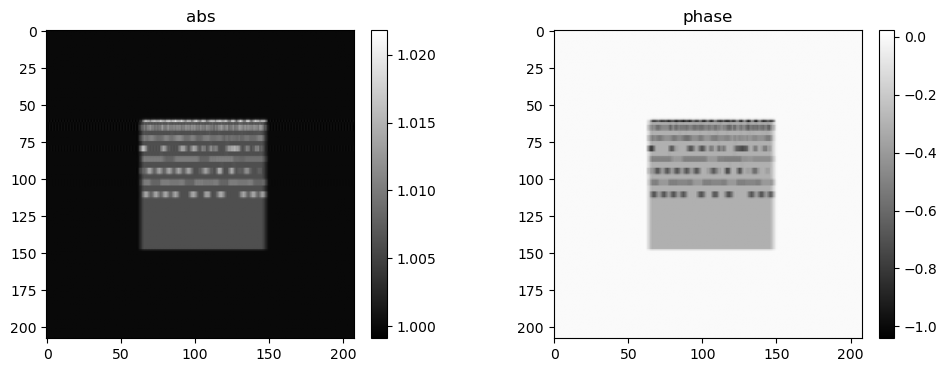

In [5]:
psi = cl_rec.expR(cl_rec.R(u))
mshow_polar(psi[2],True)
np.save('psi',psi)

## Read probe

In [6]:
!wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_abs_2048.tiff -P ../data/prb_id16a
!wget -nc https://g-110014.fd635.8443.data.globus.org/holotomocupy/examples_synthetic/data/prb_id16a/prb_phase_2048.tiff -P ../data/prb_id16a

prb_abs = read_tiff(f'../data/prb_id16a/prb_abs_2048.tiff')[0:ndist]
prb_phase = read_tiff(f'../data/prb_id16a/prb_phase_2048.tiff')[0:ndist]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')


for k in range(2):
    prb = prb[:, ::2]+prb[:, 1::2]
    prb = prb[:, :, ::2]+prb[:, :, 1::2]/4

prb = prb[:, 128+64:-128-64, 128+64:-128-64]
prb /= np.mean(np.abs(prb))


# mshow_polar(prb[0])
q=prb

# q = cp.zeros([ntheta,ndist,n,n],dtype='complex64')
# q += 0.05*(cp.random.random([ntheta,ndist,n,n]).astype('complex64')+1j*cp.random.random([ntheta,ndist,n,n]).astype('complex64'))

# v = np.arange(-(n)//2,(n)//2)/(n)
# [vx,vy] = np.meshgrid(v,v)
# v=np.exp(-4*(vx**2+vy**2))
# q = np.fft.fftshift(np.fft.fftn(np.fft.fftshift(q)))
# q = np.fft.fftshift(np.fft.ifftn(np.fft.fftshift(q*v)))
q = q.astype('complex64')

np.save('q',q)
q=cp.load('q.npy')
#q[:]=1
# mshow_polar(q[0],True)

File ‘../data/prb_id16a/prb_abs_2048.tiff’ already there; not retrieving.

File ‘../data/prb_id16a/prb_phase_2048.tiff’ already there; not retrieving.



# Shifts/drifts

In [7]:
# r = cp.load('shifts.npy')[:ntheta]#.astype('float32')#.astype('int32')#+0.5
# cp.save('shifts.npy',r)
r = ((cp.random.random([ntheta,ndist,2])-0.5)*2).astype('float32')
np.save('shifts',r)

# rerr = cp.load('shifts_err.npy')[:ntheta]#.astype('float32')
#cp.save('shifts_err.npy',rerr)
rerr = ((cp.random.random([ntheta,ndist,2])-0.5)*2).astype('float32')/2
# rerr[:128]=cp.load('shifts_err.npy')#[:ntheta]
np.save('shifts_err',rerr)


In [8]:
a = (cp.random.random(u.shape)+1j*cp.random.random(u.shape)).astype('complex64')
b = cl_rec.R(a)
c = cl_rec.RT(b)
print(np.sum(np.conj(a)*c))
print(np.sum(np.conj(b)*b))

a = (cp.random.random([ntheta,n,n])+1j*cp.random.random([ntheta,n,n])).astype('complex64')
b = cl_rec.D(a,ndist-1)
c = cl_rec.DT(b,ndist-1)
print(np.sum(np.conj(a)*c))
print(np.sum(np.conj(b)*b))

# a = (cp.random.random([ntheta,npsi,npsi])+1j*cp.random.random([ntheta,npsi,npsi])).astype('complex64')
# b = cl_rec.M(a,ndist-1)
# c = cl_rec.MT(b,ndist-1)
# print(np.sum(np.conj(a)*c))
# print(np.sum(np.conj(b)*b))

a = (cp.random.random([ntheta,npsi,npsi])+1j*cp.random.random([ntheta,npsi,npsi])).astype('complex64')
# # b = cl_rec.S(r[:,-1],a)
# # c = cl_rec.ST(r[:,-1],b)
# b = cl_rec.curlyS(a,r[:,-1],1/norm_magnifications[-1])
# c = cl_rec.curlySadj(b,r[:,-1],1/norm_magnifications[-1])
# print(np.sum(np.conj(a)*c))
# print(np.sum(np.conj(b)*b))

(4568500.5-0.2645235j)
(4568499.5+3.1151758e-05j)
(1397649.9-0.006261659j)
(1397650.1-3.0448118e-06j)


# Simulate data

In [9]:
# data = cl_rec.fwd(r+rerr,u,q)
# ref = cl_rec.fwd(r*0,u*0,q)[0,:]
# data = np.abs(data)**2
# ref = np.abs(ref)**2
psi = cl_rec.expR(cl_rec.R(u))
data = cp.zeros([ntheta,ndist,n,n],dtype='float32')
ref = cp.zeros([ndist,n,n],dtype='float32')
for j in range(ndist):
    data[:, j] = cp.abs(cl_rec.D(q[j] * cl_rec.curlyS(psi,r[:,j]+rerr[:,j],1/cl_rec.norm_magnifications[j]),j))**2    
for j in range(ndist):
    ref[j] = (cp.abs(cl_rec.D(q[j] * cl_rec.curlyS(psi*0+1,r[:,j]+rerr[:,j],1/cl_rec.norm_magnifications[j]),j))**2)[0]

3239.1099
(128, 4, 128, 128) float32


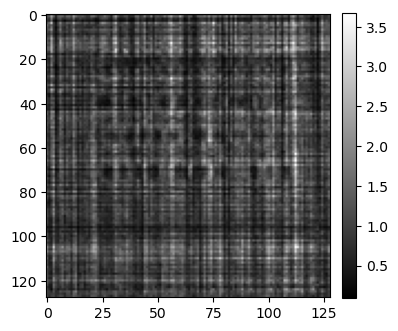

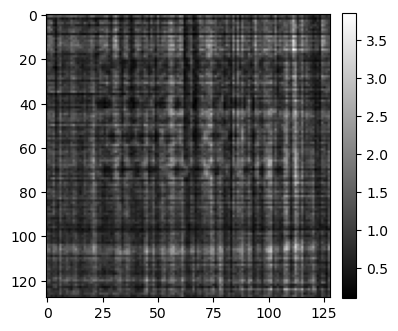

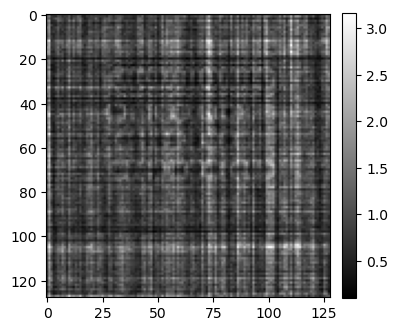

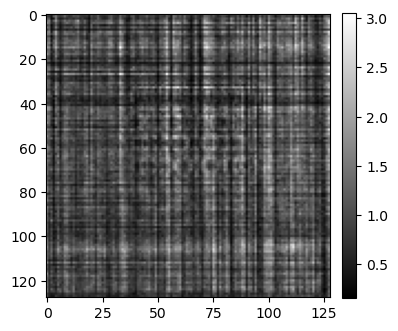

In [10]:
print(cp.linalg.norm(data))
data+=0.005*(cp.random.random([ntheta,ndist,n,n],dtype='float32')-0.5)*2
ref+=0.005*(cp.random.random([ndist,n,n],dtype='float32')-0.5)*2
print(data.shape,data.dtype)
for k in range(ndist):
    mshow(data[0,k],True)

#ss2931.72

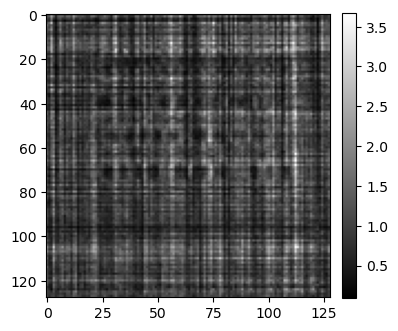

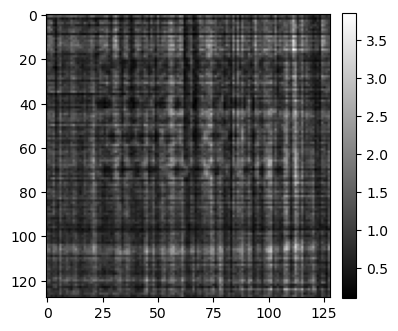

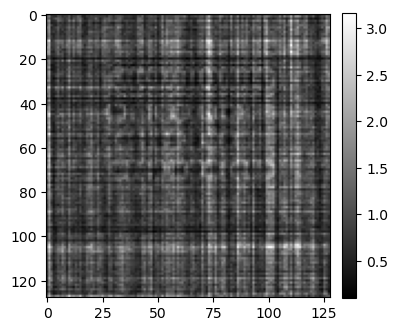

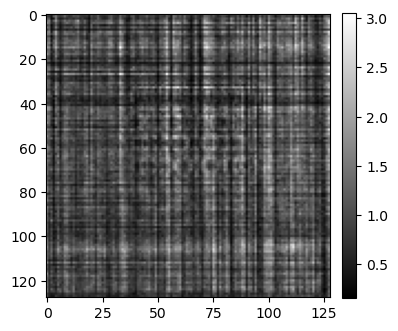

In [11]:
for k in range(ndist):
    mshow(data[0,k],True)


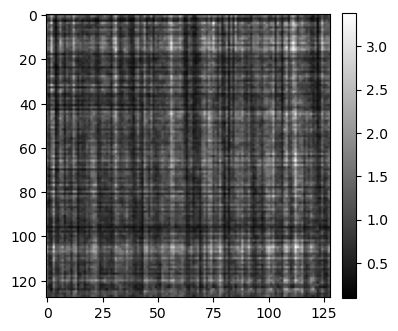

In [12]:
mshow(ref[0],True)

### Save data, reference images

In [13]:
np.save('data',data)
np.save('ref',ref)

print(np.linalg.norm(data))
print(np.linalg.norm(ref))

3239.119
284.15903
